<a href="https://colab.research.google.com/github/the77hnx/works-in-the-univ/blob/main/Happy_Labo_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG16**

In [1]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [2]:
# تحميل البيانات
train_dir = "/content/Happy Labo/train"
test_dir = "/content/Happy Labo/test"

In [3]:
# 1. تجهيز البيانات
def load_images_from_directory(directory, img_size=(224, 224)):
    images = []
    labels = []
    for label_folder in os.listdir(directory):  # سعيد أو حزين
        label_path = os.path.join(directory, label_folder)
        if os.path.isdir(label_path):
            label = 0 if label_folder.lower() == "happy" else 1  # 0: سعيد، 1: حزين
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                try:
                    img = tf.keras.utils.load_img(image_path, target_size=img_size)
                    img = tf.keras.utils.img_to_array(img) / 255.0
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
    return np.array(images), np.array(labels)

In [4]:
# 2. اعادة تسمية البيانات
def rename_images_in_directory(directory):
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            prefix = folder_name.lower().replace(" ", "_")  # تحويل الاسم إلى lowercase واستبدال المسافات بـ _
            for idx, filename in enumerate(os.listdir(folder_path)):
                file_path = os.path.join(folder_path, filename)
                file_extension = os.path.splitext(filename)[1]  # استخراج الامتداد مثل .jpg أو .png
                new_name = f"{prefix}{idx + 1}{file_extension}"  # تسمية الملف الجديد بالتسلسل
                new_path = os.path.join(folder_path, new_name)
                os.rename(file_path, new_path)
                print(f"Renamed: {file_path} -> {new_path}")

In [5]:
def count_images_in_directory(directory):
    category_counts = {}
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            category_counts[folder_name] = num_images
    return category_counts

In [6]:
# حساب توزيع البيانات
train_counts = count_images_in_directory(train_dir)
test_counts = count_images_in_directory(test_dir)

In [7]:
# رسم البيانات
def plot_data_distribution(data_counts, title):
    categories = list(data_counts.keys())
    counts = list(data_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(categories, counts, color=['skyblue', 'salmon'])
    plt.xlabel("Categories")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [8]:
def preview_images(directory, category, num_images=5):
    folder_path = os.path.join(directory, category)
    images = os.listdir(folder_path)[:num_images]
    plt.figure(figsize=(10, 5))
    for idx, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(image)
        plt.title(category)
        plt.axis("off")
    plt.show()

In [9]:
def analyze_image_sizes(directory):
    sizes = []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            with Image.open(image_path) as img:
                sizes.append(img.size)
    return sizes

In [10]:
def check_corrupted_images(directory):
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # تحقق من الصورة
            except (IOError, SyntaxError):
                print(f"Corrupted image found: {image_path}")

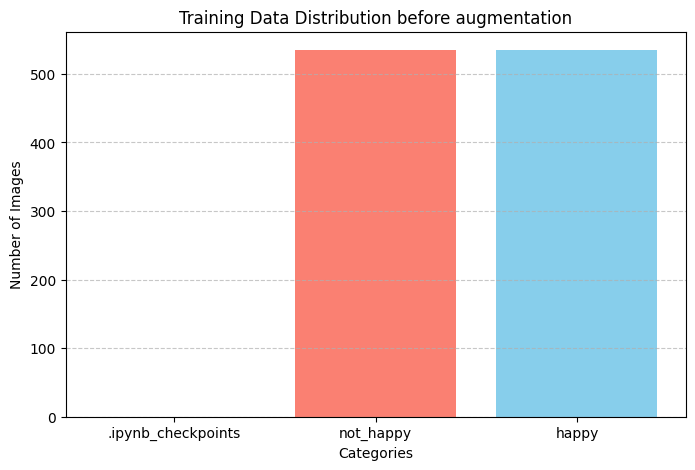

In [11]:
# رسم توزيع بيانات التدريب قبل aug
plot_data_distribution(train_counts, "Training Data Distribution before augmentation")

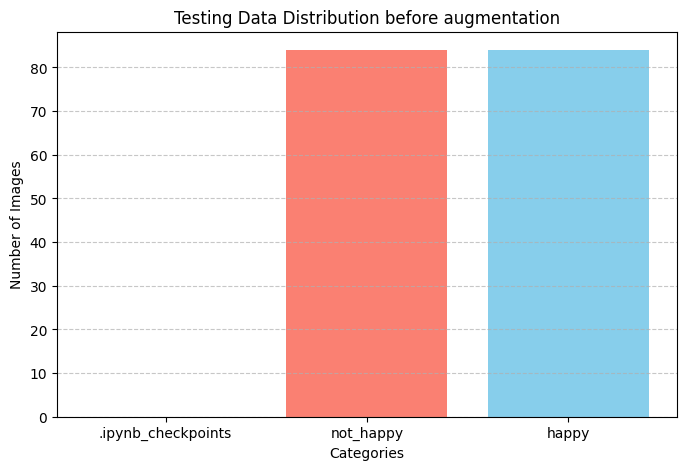

In [12]:
# رسم توزيع بيانات الاختبار قبل aug
plot_data_distribution(test_counts, "Testing Data Distribution before augmentation")

In [13]:
# إعداد مولد البيانات مع التحويلات المطلوبة
datagen = ImageDataGenerator(
    rotation_range=20,          # التدوير حتى 20 درجة
    width_shift_range=0.2,      # الإزاحة الأفقية بنسبة تصل إلى 20%
    height_shift_range=0.2,     # الإزاحة العمودية بنسبة تصل إلى 20%
    shear_range=0.2,            # الإزاحة الزاويّة (Shear)
    zoom_range=0.2,             # التكبير بنسبة تصل إلى 20%
    horizontal_flip=True,       # الانعكاس الأفقي
    fill_mode='nearest'         # ملء المساحات الفارغة
)

# مسارات الملفات
input_directory = "/content/Happy Labo/train"  # مسار مجلد التدريب
output_directory = "/content/Happy Labo/train"  # مجلد حفظ الصور الجديدة

# التأكد من إنشاء المجلد الجديد إذا لم يكن موجودًا
os.makedirs(output_directory, exist_ok=True)

# معالجة كل الصور في المجلدات الفرعية
for subdir in os.listdir(input_directory):
    subdir_path = os.path.join(input_directory, subdir)
    if os.path.isdir(subdir_path):  # التأكد من أن العنصر مجلد
        # إنشاء مجلد فرعي لحفظ الصور الجديدة
        output_subdir = os.path.join(output_directory, subdir)
        os.makedirs(output_subdir, exist_ok=True)

        # معالجة الصور
        for img_name in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # التأكد من أن الملف صورة
                img = load_img(img_path)  # تحميل الصورة
                x = img_to_array(img)  # تحويل الصورة إلى مصفوفة
                x = x.reshape((1,) + x.shape)  # إضافة بعد جديد

                # توليد الصور الجديدة
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=output_subdir, save_prefix='aug', save_format='jpg'):
                    i += 1
                    if i >= 5:  # إنشاء 5 صور جديدة لكل صورة أصلية
                        break

print("تم إنشاء زيادة البيانات وحفظها في:", output_directory)


تم إنشاء زيادة البيانات وحفظها في: /content/Happy Labo/train


In [14]:
# مسارات الملفات
input_directory = "/content/Happy Labo/test"  # مسار مجلد التدريب
output_directory = "/content/Happy Labo/test"  # مجلد حفظ الصور الجديدة

# التأكد من إنشاء المجلد الجديد إذا لم يكن موجودًا
os.makedirs(output_directory, exist_ok=True)

# معالجة كل الصور في المجلدات الفرعية
for subdir in os.listdir(input_directory):
    subdir_path = os.path.join(input_directory, subdir)
    if os.path.isdir(subdir_path):  # التأكد من أن العنصر مجلد
        # إنشاء مجلد فرعي لحفظ الصور الجديدة
        output_subdir = os.path.join(output_directory, subdir)
        os.makedirs(output_subdir, exist_ok=True)

        # معالجة الصور
        for img_name in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # التأكد من أن الملف صورة
                img = load_img(img_path)  # تحميل الصورة
                x = img_to_array(img)  # تحويل الصورة إلى مصفوفة
                x = x.reshape((1,) + x.shape)  # إضافة بعد جديد

                # توليد الصور الجديدة
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=output_subdir, save_prefix='aug', save_format='jpg'):
                    i += 1
                    if i >= 5:  # إنشاء 5 صور جديدة لكل صورة أصلية
                        break

print("تم إنشاء زيادة البيانات وحفظها في:", output_directory)


تم إنشاء زيادة البيانات وحفظها في: /content/Happy Labo/test


In [15]:
# حساب توزيع البيانات
train_counts_after_aug = count_images_in_directory(train_dir)
test_counts_after_aug = count_images_in_directory(test_dir)

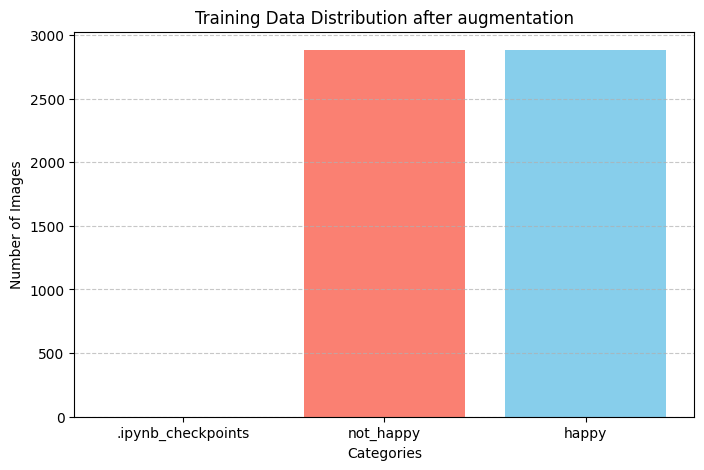

In [16]:
# رسم توزيع بيانات التدريب بعد aug
plot_data_distribution(train_counts_after_aug, "Training Data Distribution after augmentation")

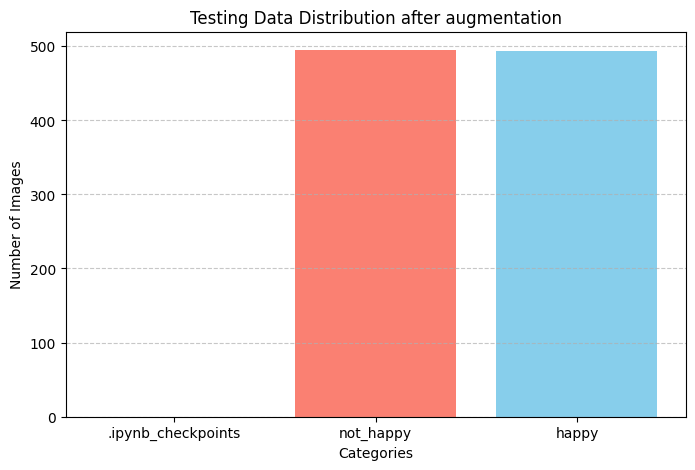

In [17]:
# رسم توزيع بيانات الاختبار بعد aug
plot_data_distribution(test_counts_after_aug, "Testing Data Distribution after augmentation")

In [ ]:
# اعادة تسمية صور التدريب والاختبار
rename_images_in_directory(train_dir)
rename_images_in_directory(test_dir)

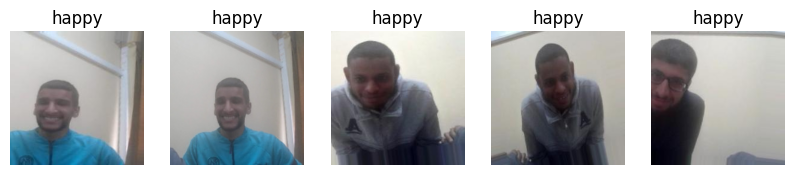

In [19]:
preview_images(train_dir, "happy")

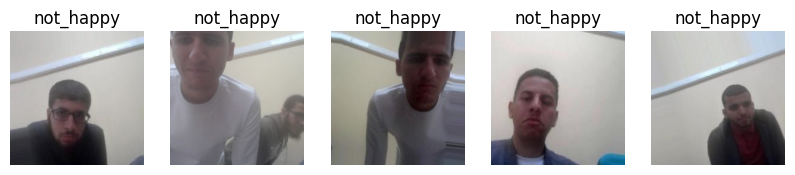

In [20]:
preview_images(train_dir, "not_happy")

In [21]:
check_corrupted_images(train_dir)

In [22]:
train_sizes = analyze_image_sizes(train_dir)
print(f"Example Sizes in Training Data: {train_sizes[:2]}")

Example Sizes in Training Data: [(224, 224), (224, 224)]


In [7]:
# تحميل صور التدريب والاختبار
x_train, y_train = load_images_from_directory(train_dir)
x_test, y_test = load_images_from_directory(test_dir)

In [8]:
print("shape of x_train : ", x_train.shape)
print("shape of x_test : ", x_test.shape)
print("shape of y_train : ", y_train.shape)
print("shape of y_test : ", y_test.shape)

shape of x_train :  (5763, 224, 224, 3)
shape of x_test :  (989, 224, 224, 3)
shape of y_train :  (5763,)
shape of y_test :  (989,)


In [9]:
# 2. بناء نموذج VGG16
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [10]:
# تجميد الطبقات الأساسية
for layer in base_model.layers:
    layer.trainable = False

In [11]:
# تجميع النموذج
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,926,338 (68.38 MB)

 Trainable params: 3,211,650 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# إعداد التوقف المبكر
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
    mode='max',
    baseline=0.97,
    restore_best_weights=True
)

In [14]:
# تدريب النموذج
history = model.fit(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - accuracy: 0.7123 - loss: 0.7347 - val_accuracy: 0.6999 - val_loss: 0.5673
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 56s 169ms/step - accuracy: 0.8977 - loss: 0.2525 - val_accuracy: 0.9497 - val_loss: 0.1468
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - accuracy: 0.9330 - loss: 0.1652 - val_accuracy: 0.8881 - val_loss: 0.2597
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.9630 - loss: 0.0976 - val_accuracy: 0.8656 - val_loss: 0.3340
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.9695 - loss: 0.0798 - val_accuracy: 0.9532 - val_loss: 0.1215
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - accuracy: 0.9692 - loss: 0.0735 - val_accuracy: 0.9471 - val_loss: 0.1319
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.9797 - loss: 0.0570 - val_accuracy: 0.9662 - val_loss: 0.0878
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9749 - loss: 0

In [15]:
del train_counts
del test_counts
del train_counts_after_aug
del test_counts_after_aug
del output_directory
del input_directory
del output_subdir
del subdir_path
del subdir
del img_name
del img_path
del img
del x
del i
del datagen
del check_corrupted_images
del preview_images
del analyze_image_sizes
del rename_images_in_directory
del count_images_in_directory
del plot_data_distribution
del load_images_from_directory
del early_stopping

In [16]:
# 3. استخراج الميزات وتدريب KNN
feature_extractor = Model(inputs=base_model.input, outputs=x)  # طبقة الميزات


In [ ]:
train_features = feature_extractor.predict(x_train)

In [ ]:
# تدريب KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, y_train)

In [ ]:
print("Number of neighbors:", knn.n_neighbors)

In [ ]:
print("Metric used:", knn.metric)

In [ ]:
# التحقق باستخدام KNN
test_features = feature_extractor.predict(x_test)

In [ ]:
# حساب المسافات داخل الفئات (Intra-class distances)
intra_distances = []
for i in range(len(train_features)):
    for j in range(i+1, len(train_features)):
        if y_train[i] == y_train[j]:  # نفس الفئة
            dist = np.linalg.norm(train_features[i] - train_features[j])
            intra_distances.append(dist)

# حساب المسافات بين الفئات (Inter-class distances)
inter_distances = []
for i in range(len(train_features)):
    for j in range(len(train_features)):
        if y_train[i] != y_train[j]:  # فئات مختلفة
            dist = np.linalg.norm(train_features[i] - train_features[j])
            inter_distances.append(dist)

# رسم المنحنيات
plt.figure(figsize=(10, 6))
plt.hist(intra_distances, bins=30, alpha=0.7, label='Intra-class distances', color='blue')
plt.hist(inter_distances, bins=30, alpha=0.7, label='Inter-class distances', color='red')
plt.axvline(x=np.mean(intra_distances), color='blue', linestyle='--', label='Mean Intra-class distance')
plt.axvline(x=np.mean(inter_distances), color='red', linestyle='--', label='Mean Inter-class distance')
plt.title('Distribution of Intra-class and Inter-class Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# حساب المسافات بين النقاط في مجموعة الاختبار
distances, _ = knn.kneighbors(test_features)

In [ ]:
# تحديد العتبة للمقارنة
threshold = 0.8

In [ ]:
# قائمة لتخزين التنبؤات
predictions = []

# تحقق من المسافة بين النقاط
for dist in distances:
    if np.min(dist) < threshold:  # إذا كانت المسافة أقل من العتبة
        predictions.append(1)  # الشخص هو نفسه
    else:
        predictions.append(0)  # الشخص ليس نفسه


In [ ]:
# predictions = knn.predict(test_features)

In [ ]:
# حساب الدقة
accuracy = accuracy_score(y_test, predictions)
print("Accuracy of KNN with Threshold:", accuracy)

In [ ]:
# Generate predictions for validation set
y_pred = knn.predict(test_features)

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Happy', 'Happy'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Normalize the confusion matrix to display percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Not Happy', 'Happy'], yticklabels=['Not Happy', 'Happy'])
plt.title("Confusion Matrix as Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Visualize a few predictions
num_samples = 8
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    idx = random.randint(0, len(x_test) - 1)
    img = x_test[idx]
    true_label = "Happy" if y_test[idx] == 1 else "Not Happy"
    pred_label = "Happy" if y_pred[idx] == 1 else "Not Happy"

    # Plot image
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import random

# تحديث القاموس للتصنيفات الجديدة
categories = {
    0: "Member Happy",
    1: "Member Not Happy",
    2: "Not Member Happy",
    3: "Not Member Not Happy"
}


In [ ]:

# تحديث عملية التنبؤ
threshold = 0.8  # العتبة لتحديد حالة العضوية
predictions = []

for dist, y_pred_label in zip(distances, knn.predict(test_features)):
    if np.min(dist) < threshold:
        # Member
        if y_pred_label == 1:
            predictions.append(3)  # Member Happy
        else:
            predictions.append(2)  # Member Not Happy
    else:
        # Not Member
        if y_pred_label == 1:
            predictions.append(1)  # Not Member Happy
        else:
            predictions.append(0)  # Not Member Not Happy

# تحديث دقة KNN مع التصنيفات الجديدة
accuracy = accuracy_score(y_test, predictions)
print("Accuracy of KNN with Member Classification:", accuracy)


In [ ]:

# إنشاء مصفوفة الالتباس مع التصنيفات الجديدة
cm = confusion_matrix(y_test, predictions)

# عرض مصفوفة الالتباس
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(categories.values()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix with Member Classification")
plt.show()


In [ ]:

# تطبيع مصفوفة الالتباس للعرض كنسب مئوية
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# رسم خريطة حرارية لمصفوفة الالتباس
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=list(categories.values()), yticklabels=list(categories.values()))
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:

# عرض صور مع التصنيفات الجديدة
num_samples = 8
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    idx = random.randint(0, len(x_test) - 1)
    img = x_test[idx]

    # توقعات النموذج
    pred_category = predictions[idx]
    pred_label = categories[pred_category]

    # التسمية الحقيقية
    true_label = categories[y_test[idx]]

    # عرض الصورة
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
model.save('vgg16_knn_model.h5')


In [ ]:
# مكتبات لتحميل الملفات ومعالجة الصور
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# تحميل صورة من الجهاز
uploaded = files.upload()

# التحقق إذا تم تحميل ملف
if uploaded:
    # الحصول على اسم الملف
    file_name = list(uploaded.keys())[0]

    # تحميل الصورة ومعالجتها
    img = load_img(file_name, target_size=(224, 224))  # تغيير حجم الصورة لتتناسب مع مدخلات النموذج
    img_array = img_to_array(img) / 255.0  # تحويل الصورة إلى مصفوفة وتقسيم القيم على 255 للتطبيع
    img_array = np.expand_dims(img_array, axis=0)  # إضافة بُعد جديد للصورة (لتتوافق مع مدخلات النموذج)

    # استخراج الميزات باستخدام النموذج الأساسي
    features = feature_extractor.predict(img_array)

    # التنبؤ باستخدام KNN
    distances, _ = knn.kneighbors(features)
    knn_pred = knn.predict(features)[0]

    # التحقق من العضوية بناءً على المسافة
    if np.min(distances) < threshold:
        # عضو
        if knn_pred == 1:
            prediction = "Member Happy"
        else:
            prediction = "Member Not Happy"
    else:
        # غير عضو
        if knn_pred == 1:
            prediction = "Not Member Happy"
        else:
            prediction = "Not Member Not Happy"

    # عرض النتيجة
    print(f"The image is classified as: {prediction}")

    # عرض الصورة مع النتيجة
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {prediction}")
    plt.show()
else:
    print("No file was uploaded.")
